In [18]:
%load_ext autoreload
%autoreload 2

from wb_api_wraper import *

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

from IPython.display import display, HTML

import matplotlib.pyplot as plt 
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
#Pandas display options
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.width', 200)
pd.set_option('display.precision', 2)
pd.set_option('display.max_rows', 20)

In [20]:
#Options for plots
font = {'family' : 'serif',
    'weight' : 'normal',
    'size'   : 12}

plt.rc('font', **font)
plt.rcParams["legend.fancybox"]=True
plt.rcParams["savefig.dpi"]=90

plot_options = dict(alpha=0.5,clip_on=False)

def format_fig(ax):
    ax.set_xlim(0)
    ax.set_ylim(0)

In [290]:
#Searching the WB API database

search_wb("GDP");
search_wb("emissions");

#Data

In [326]:
gni = True #use GDP per capita if if false

In [402]:
all_ghg = False  #use only CO2 if false, all GHG if true

###Pop and gdp

In [403]:
#gdp_pc_ppp  = get_wb("NY.GNP.PCAP.PP.CD") if gni else get_wb("NY.GDP.PCAP.PP.CD")#GDP per capita, PPP (constant 2011 international $)
gdp = get_wb("NY.GDP.MKTP.PP.KD")#GGDP, PPP (constant 2011 international $)
pop = get_wb("SP.POP.TOTL") #population

gdp_pc_ppp=

In [404]:
#(pop*gdp_pc_ppp)/gdp #sanity check: pop, gdp and gdp_pc are consistent, notably in recent years

###Emissions

In [460]:
if all_ghg:
    other_ghg_tot = (get_wb("EN.ATM.METH.KT.CE")  #total methane
                      +get_wb("EN.ATM.NOXE.KT.CE")  #total nitrous o
                      +get_wb("EN.ATM.GHGO.KT.CE") #total other
                      )*1000 #emissions in tons


    for c in range(2000,2011):
        if str(c) not in other_ghg_tot.columns:
            other_ghg_tot[str(c)]=np.nan


    from scipy.interpolate import interp1d

    other_ghg_tot=other_ghg_tot.sort_index(axis=1).interpolate(axis=1)
    other_ghg_tot["2011"]=2*other_ghg_tot["2010"]-other_ghg_tot["2009"]

    emis_tot=(emis_tot+other_ghg_tot).fillna(emis_tot)
    
    emis_intens = emis_tot /gdp 

else:
    #emis_intens = get_wb_mrv("EN.ATM.CO2E.KD.GD","emis_intens") /1000 #CO2 emissions (data in kg per 2005 US$ of GDP), converted in tons per ...
    #emis_intens = get_wb("EN.ATM.CO2E.PP.GD.KD")/1000 #CO2 emissions in tons, from  #CO2 emissions (kg per 2011 PPP $ of GDP)
    emis_tot = get_wb("EN.ATM.CO2E.KT")*1000 #emissions in tons
    #Both series end in 2011
    
emis_intens = emis_tot /gdp 

In [461]:
other_ghg_tot["2011"].sum()

66038056000.0

In [462]:
#(emis_intens*gdp/emis_tot) #sanity check: these amtch exactly (intens must be computed this way)

###Dataframe

In [463]:
#Income gorups for countries and HIPC status
groups = pd.read_csv("counry_income_groups.csv",header =4,index_col=2).replace({"ROM":"ROU","ZAR":"COD"})  #they used old iso3 country for Zair (Congo) and Romania
groups.dropna(axis=0,how="all",inplace=True);

In [464]:
df=pd.DataFrame()
df["emis_intens"]=emis_intens.stack()
df["gdp_pc"] = gdp_pc_ppp.stack()
df["pop"] = pop.stack()
df["emis_tot"] = emis_tot.stack()

emis_pc = emis_tot.stack()/pop.stack()
df["emis_pc"]= emis_pc

df= df.ix[groups.index.values] #keeps only actula countries (no macro regions or groups of countries)

data_all = df.reset_index()

#emission intensity last year
emis_intens_peryear=data_all.set_index(["country","year"]).emis_intens.unstack()
emis_intens_last_year =emis_intens_peryear[0:-1]
emis_intens_last_year.columns=emis_intens_last_year.columns.map(lambda x: str(1+eval(x)))
emis_intens_last_year.columns.name="year"
emis_intens_last_year.stack().reset_index()

data_all=pd.merge(data_all,emis_intens_last_year.stack().reset_index(),on=["country","year"],how="outer").dropna().rename(columns={0:"emis_intens_last_year"})


#income bins
bins = [0]+ data_all.gdp_pc.quantile([.2,.4,.6,.8,1]).tolist()
bins[-1]=1e7 #"makes sure the last bins covers future incomes"
print(bins)

x=pd.cut(data_all.gdp_pc,bins);
x.name="inc_bins"

data_all = pd.concat([data_all,x],axis=1)


#dummy for 2011 to center the rpediciton there
data_all["dummy2011"]=(data_all["year"]=="2011")+0


[0, 2180.0, 5610.0, 10934.0, 25122.0, 10000000.0]


In [465]:
#Current emissions
emis_ref = data_all.dropna().query("year=='2011'").emis_tot.sum()
print("Global CO2 emissions in the sample: {emis:0.0f} GtCO2".format(emis=emis_ref*1e-9)+("eq" if all_ghg else ""))

Global CO2 emissions in the sample: 31 GtCO2


In [466]:
emissions_2030_RCP = 7*44/12
32/emissions_2030_RCP

1.2467532467532467

###Population and GDP from SSP

In [467]:
pop_proj_2050 = pd.read_csv("population_ssp.csv", index_col="country", dtype={"scenario":str}).query("scenario=='SSP4'")["2050"]*1e6
pop_proj_2050 = pop_proj_2050.sort_index().copy()
pop_proj_2050.name="pop"

In [468]:
pop_proj = pd.read_csv("population_ssp.csv", index_col="country", dtype={"scenario":str}).query("scenario=='SSP4'")["2030"]*1e6
pop_proj = pop_proj.sort_index().copy()

In [469]:
gdp_proj = pd.read_csv("gdp_ssp.csv", index_col="country", dtype={"scenario":str}).query("scenario=='SSP4'")["2030"]


In [470]:
gdp_pc_proj_2050 = pd.read_csv("gdp_ssp.csv", index_col="country", dtype={"scenario":str}).query("scenario=='SSP4'")["2050"]/ pop_proj_2050  *1e9  #GDP per capita in $
gdp_pc_proj_2050.name="gdp_pc"

###Emissions in LICs today

In [471]:
#What ending povety means
target_gdp_pc = 3500

In [472]:
data2011= data_all.query("year=='2011'").copy()
LICs = data2011.ix[data2011.gdp_pc<target_gdp_pc].index
data2011.ix[LICs].emis_tot.sum()/emis_ref*100

0.7220997788557768

In [473]:
print(data2011.ix[LICs].country.tolist())
len(LICs)

['Afghanistan', 'Bangladesh', 'Benin', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 'Congo, Dem. Rep.', 'Eritrea', 'Ethiopia', 'Gambia, The', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Haiti', 'Kenya', 'Kiribati', 'Kyrgyz Republic', 'Lesotho', 'Liberia', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mozambique', 'Nepal', 'Niger', 'Papua New Guinea', 'Rwanda', 'Senegal', 'Sierra Leone', 'Solomon Islands', 'Sudan', 'Tajikistan', 'Tanzania', 'Togo', 'Uganda', 'Vanuatu', 'Yemen, Rep.', 'Zambia']


43

#Simulations

In [474]:
def project_special(formula, data, simulation):
    print("\n"+formula)
    
    data2011= data.query("year=='2011'").copy()

    mod = smf.ols(formula, data).fit()
    mod_weighted = smf.wls(formula, data, weights = data["pop"]).fit()

    
    print("\n========= Predicted 2011")
    emis_tot =mod.predict(data2011)*data2011["gdp_pc"]*data2011["pop"]
    emis_tot_weighted =mod_weighted.predict(data2011)*data2011["gdp_pc"]*data2011["pop"]
    print("Error in 2011: {x:0.1%} (unweighted)  or {y:0.1%} (weighted)".format(
            x=emis_tot.sum()/emis_ref-1,
            y=emis_tot_weighted.sum()/emis_ref-1)
         )
    
    e_ref = emis_tot
    e_w_ref = emis_tot_weighted
    
    def report(emis_tot,emis_tot_weighted):
        print("Emissions increased by {x:0.1%} (unweighted)  or {y:0.1%} (weighted)".format(
            x=(emis_tot).sum()/emis_ref,
            y=(emis_tot_weighted).sum()/emis_ref)
         )
    
    report(emis_tot-e_ref,emis_tot_weighted-e_w_ref)
    
    
    print("prediction not de-biased")
    emis_tot =mod.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    emis_tot_weighted =mod_weighted.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    
    return mod,mod_weighted,emis_tot,emis_tot_weighted
    

###Projections of emissions in 2050

In [475]:
simulation_2050=pd.concat([pop_proj_2050,gdp_pc_proj_2050],axis=1).dropna()
simulation_2050=simulation_2050.ix[data_all.dropna().country.unique()].reset_index().rename(columns={"index":"country"}).dropna()
simulation_2050["inc_bins"]=pd.cut(simulation_2050.gdp_pc,bins)
simulation_2050.head(3)

,country,pop,gdp_pc,inc_bins
0,Afghanistan,87831301.4,2616.7,"(2180, 5610]"
1,Albania,3004167.8,18734.3,"(10934, 25122]"
2,Algeria,46018487.4,16668.0,"(10934, 25122]"


In [476]:
formula = 'emis_intens ~ country- 1 '
data=data_all
simulation=simulation_2050

data2011= data.query("year=='2011'").copy()

In [477]:
mod = smf.ols(formula, data2011).fit()
mod_weighted = smf.wls(formula, data2011, weights = data2011["pop"]).fit()

In [478]:
emis_tot =mod.predict(data2011)*data2011["gdp_pc"]*data2011["pop"]
emis_tot_weighted =mod_weighted.predict(data2011)*data2011["gdp_pc"]*data2011["pop"]
print("Error in 2011: {x:0.1%} (unweighted)  or {y:0.1%} (weighted)".format(
        x=emis_tot.sum()/emis_ref-1,
        y=emis_tot_weighted.sum()/emis_ref-1)
     )
e_ref = emis_tot
e_w_ref = emis_tot_weighted


def report(emis_tot,emis_tot_weighted):
    print("Emissions increased by {x:0.1%} (unweighted)  or {y:0.1%} (weighted)".format(
        x=(emis_tot).sum()/emis_ref,
        y=(emis_tot_weighted).sum()/emis_ref)
     )

report(emis_tot-e_ref,emis_tot_weighted-e_w_ref)

Error in 2011: -0.7% (unweighted)  or -0.7% (weighted)
Emissions increased by 0.0% (unweighted)  or 0.0% (weighted)


In [479]:
simulation_2050['emis_tot_proj'] =mod.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
simulation_2050['emis_tot_weighted'] =mod_weighted.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
report(simulation_2050['emis_tot']-e_ref,simulation_2050['emis_tot_weighted']-e_w_ref)

PatsyError: Error converting data to categorical: observation with value 'Brunei Darussalam' does not match any of the expected levels (expected: ['Afghanistan', 'Albania', ..., 'Yemen, Rep.', 'Zambia'])
    emis_intens ~ country- 1
                  ^^^^^^^

In [ ]:
hop=pd.merge(data2011,simulation_2050[["country","emis_tot_proj","emis_tot_weighted"]],on="country").set_index("country")

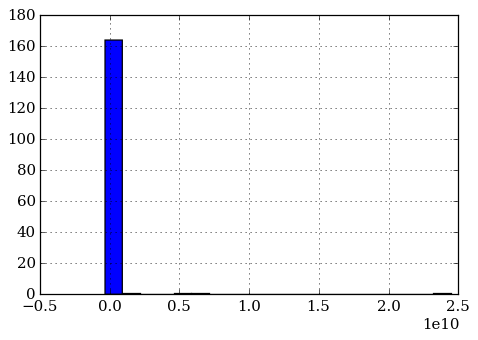

In [480]:
(hop.emis_tot_proj-hop.emis_tot).hist(bins=20)

In [481]:
formula="emis_intens ~ gdp_pc+country- 1 "
mod,mod_weighted,emis_tot,emis_tot_weighted = project_special(formula, data_all, simulation_2050)
mod.summary();

emis_tot


emis_intens ~ gdp_pc+country- 1 

========= Predicted 2011
Error in 2011: 3.0% (unweighted)  or -1.9% (weighted)
Emissions increased by 0.0% (unweighted)  or 0.0% (weighted)
prediction not de-biased


0      2.3e+07
1      7.6e+06
2      1.7e+08
3      6.9e+07
5      8.8e+06
6      6.4e+08
7      4.1e+07
8      6.3e+07
9      1.7e+06
10     5.7e+07
        ...   
172    5.0e+08
173    6.9e+09
174    2.6e+06
175    7.2e+08
176    4.8e+05
177    3.6e+08
178    4.4e+08
179    6.9e+06
180    6.3e+07
181    9.1e+06
dtype: float64

In [482]:
def project_emissions(formula, data):
    print("\n"+formula)
    
    data2011= data.query("year=='2011'").copy()
    LICs = data2011.ix[data2011.gdp_pc.clip(lower=target_gdp_pc)==target_gdp_pc].index
    
    mod = smf.ols(formula, data).fit()
    mod_weighted = smf.wls(formula, data, weights = data["pop"]).fit()

    
    print("\n========= Predicted 2011")
    simulation = data2011
    emis_tot =mod.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    emis_tot_weighted =mod_weighted.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    print("Error in 2011: {x:0.1%} (unweighted)  or {y:0.1%} (weighted)".format(
            x=emis_tot.sum()/emis_ref-1,
            y=emis_tot_weighted.sum()/emis_ref-1)
         )
    
    e_ref = emis_tot
    e_w_ref = emis_tot_weighted
    
    
    def report(emis_tot,emis_tot_weighted):
        print("Emissions increased by {x:0.1%} (unweighted)  or {y:0.1%} (weighted)".format(
            x=(emis_tot).sum()/emis_ref,
            y=(emis_tot_weighted).sum()/emis_ref)
         )
    
    report(emis_tot-e_ref,emis_tot_weighted-e_w_ref)
    
    print("\n========= Liting Income")
    simulation = data2011.assign(gdp_pc = data.gdp_pc.clip(lower=target_gdp_pc), inc_bins = pd.cut(data2011.gdp_pc,bins))
    emis_tot =mod.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    emis_tot_weighted =mod_weighted.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    report(emis_tot-e_ref,emis_tot_weighted-e_w_ref)
    
    print('\n==========Liting Income and population')
    simulation = data2011.assign(gdp_pc = data.gdp_pc.clip(lower=target_gdp_pc),inc_bins = pd.cut(data2011.gdp_pc,bins) )
    simulation.ix[LICs,"pop"] = pop_proj.ix[data.ix[LICs].country].values
    
    emis_tot =mod.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    emis_tot_weighted =mod_weighted.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    report(emis_tot-e_ref,emis_tot_weighted-e_w_ref)
    
    print('\n==========new POPULATION, old income')
    simulation = data2011
    simulation.ix[LICs,"pop"] = pop_proj.ix[data.ix[LICs].country].values
    emis_tot =mod.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]

    emis_tot_weighted =mod_weighted.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    report(emis_tot-e_ref,emis_tot_weighted-e_w_ref)
    #simulation["emis_tot_weighted"] =mod.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    
    #simulation["emis_intens_pred"]
    #simulation["emis_pc"] = simulation["emis_intens_pred"]
    #simulation["emis_tot"] = simulation["emis_pc"]

    #print("\nEmissions increased by {x:0.1%}[{cil:0.1%}, {ciu:0.1%}]".format(
    #        x  =simulation.emis_tot.sum()/emis_ref-1,
    #        ciu=(simulation.emis_tot*iv_u/simulation["emis_intens_pred"]).sum()/emis_ref-1,
    #        cil=(simulation.emis_tot*iv_l/simulation["emis_intens_pred"]).sum()/emis_ref-1
    #     ))
    

    
    return mod,mod_weighted
    

###Constant emission intensity using 2011 data

In [483]:
formula="emis_intens ~ country - 1"

In [484]:
data2011.emis_tot.sum()/emis_ref-1

0.0

In [485]:
print("\n========= Predicted 2011")
simulation = data2011
emis_tot =mod.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
emis_tot_weighted =mod_weighted.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
print("Error in 2011: {x:0.1%} (unweighted)  or {y:0.1%} (weighted)".format(
        x=emis_tot.sum()/emis_ref-1,
        y=emis_tot_weighted.sum()/emis_ref-1)
     )


========= Predicted 2011
Error in 2011: 3.0% (unweighted)  or -1.9% (weighted)


In [486]:
mod, mod_w= project_emissions(formula, data_all.query("year=='2011'").copy())
mod.summary();


emis_intens ~ country - 1

========= Predicted 2011
Error in 2011: -0.7% (unweighted)  or -0.7% (weighted)
Emissions increased by 0.0% (unweighted)  or 0.0% (weighted)

========= Liting Income
Emissions increased by 0.5% (unweighted)  or 0.5% (weighted)

==========Liting Income and population
Emissions increased by 1.1% (unweighted)  or 1.1% (weighted)

==========new POPULATION, old income
Emissions increased by 0.3% (unweighted)  or 0.3% (weighted)


In [443]:
mod, mod_w= project_emissions(formula, data_all)


emis_intens ~ country - 1

========= Predicted 2011
Error in 2011: 8.8% (unweighted)  or 8.7% (weighted)
Emissions increased by 0.0% (unweighted)  or 0.0% (weighted)

========= Liting Income
Emissions increased by 0.4% (unweighted)  or 0.4% (weighted)

==========Liting Income and population
Emissions increased by 1.0% (unweighted)  or 1.0% (weighted)

==========new POPULATION, old income
Emissions increased by 0.3% (unweighted)  or 0.3% (weighted)


###Country fix effect and gdpglobal effect

everything signigicant

In [426]:
formula="emis_intens ~ gdp_pc+country- 1 "

mod, mod_w  = project_emissions(formula, data_all)
#foo.summary()
mod.summary();


emis_intens ~ gdp_pc+country- 1 

========= Predicted 2011
Error in 2011: 3.0% (unweighted)  or -1.9% (weighted)
Emissions increased by 0.0% (unweighted)  or 0.0% (weighted)

========= Liting Income
Emissions increased by 0.4% (unweighted)  or 0.3% (weighted)

==========Liting Income and population
Emissions increased by 0.9% (unweighted)  or 0.8% (weighted)

==========new POPULATION, old income
Emissions increased by 0.3% (unweighted)  or 0.3% (weighted)


In [433]:
formula="emis_intens ~ gdp_pc+country + emis_intens_last_year- 1"

mod, mod_w  = project_emissions(formula, data_all)
#foo.summary()
mod.summary();


emis_intens ~ gdp_pc+country + emis_intens_last_year- 1

========= Predicted 2011
Error in 2011: -0.5% (unweighted)  or -1.6% (weighted)
Emissions increased by 0.0% (unweighted)  or 0.0% (weighted)

========= Liting Income
Emissions increased by 0.4% (unweighted)  or 0.4% (weighted)

==========Liting Income and population
Emissions increased by 1.0% (unweighted)  or 1.0% (weighted)

==========new POPULATION, old income
Emissions increased by 0.3% (unweighted)  or 0.3% (weighted)


###Square income

In [434]:
formula="emis_intens ~ gdp_pc + I(gdp_pc**2)+ country  - 1"
mod, mod_w  = project_emissions(formula, data_all)
mod.summary();


emis_intens ~ gdp_pc + I(gdp_pc**2)+ country  - 1

========= Predicted 2011
Error in 2011: 0.1% (unweighted)  or -1.2% (weighted)
Emissions increased by 0.0% (unweighted)  or 0.0% (weighted)

========= Liting Income
Emissions increased by 0.3% (unweighted)  or 0.2% (weighted)

==========Liting Income and population
Emissions increased by 0.7% (unweighted)  or 0.6% (weighted)

==========new POPULATION, old income
Emissions increased by 0.3% (unweighted)  or 0.3% (weighted)


###income bins

In [436]:
formula="emis_intens ~ gdp_pc:inc_bins+country - 1"
mod, mod_w  = project_emissions(formula, data_all)

mod.summary();


emis_intens ~ gdp_pc:inc_bins+country - 1

========= Predicted 2011
Error in 2011: 2.3% (unweighted)  or -1.2% (weighted)
Emissions increased by 0.0% (unweighted)  or 0.0% (weighted)

========= Liting Income
Emissions increased by 0.8% (unweighted)  or 0.6% (weighted)

==========Liting Income and population
Emissions increased by 1.5% (unweighted)  or 1.2% (weighted)

==========new POPULATION, old income
Emissions increased by 0.3% (unweighted)  or 0.3% (weighted)


###Country fix effect, year fix effect, and gdpglobal effect

year fixed effect non significant

In [431]:
formula="emis_intens ~ gdp_pc+country+year- 1"
m,mw=project_emissions(formula, data_all)
m.summary();


emis_intens ~ gdp_pc+country+year- 1

========= Predicted 2011
Error in 2011: 2.6% (unweighted)  or -2.1% (weighted)
Emissions increased by 0.0% (unweighted)  or 0.0% (weighted)

========= Liting Income
Emissions increased by 0.4% (unweighted)  or 0.3% (weighted)

==========Liting Income and population
Emissions increased by 0.8% (unweighted)  or 0.7% (weighted)

==========new POPULATION, old income
Emissions increased by 0.3% (unweighted)  or 0.3% (weighted)


###Plots

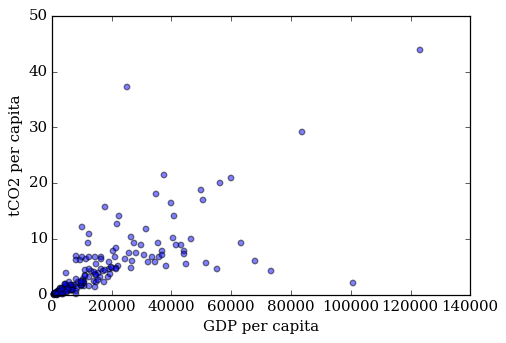

In [432]:
fig, ax = plt.subplots(1,1)
ax.scatter(data2011.gdp_pc,data2011.emis_pc,**plot_options)
ax.set_xlabel('GDP per capita')
ax.set_ylabel('tCO2 per capita')
format_fig(ax)